In [1]:
from Bio import Entrez
import os
from Bio import Medline
Entrez.email = "NCBI_EMAIL", "your.email@yourdomain"""
Entrez.api_key = os.getenv("NCBI_API_KEY")  
RATE_LIMIT = 0.34   # seconds between requests  (≈3/sec)
from tqdm import tqdm
import pandas as pd
import sqlite3
import xlrd
import plotly.graph_objects as go
import time
from retrying import retry
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [2]:


def get_count(term):
    """
    Use pubmed API to get a count of number of results for a search term
    """
    count_handle = Entrez.esearch(db="pubmed",
                                  sort="relevance",
                                  retmode="xml",
                                  retmax=0,  # Request only the count
                                  term=term)
    count_results = Entrez.read(count_handle)
    count = int(count_results["Count"])
    
    return count


def chunked_pmids(term, chunksize):
    """
    Use pubmed API to fetch blocks of PMIDs for a search term
    """
    
    count = get_count(term)
    
    retmax_requests = list(range(0, count, chunksize))
                
    pmids = []
    
    print(f"{len(retmax_requests)} blocks to process, total papers count: {count}")
    
    for i, retmax in enumerate(retmax_requests):
        
        print(f"Processing block {i + 1}/{len(retmax_requests)}")
        
        try: 
            pmid_handle = Entrez.esearch(db="pubmed",
                                         sort="relevance",
                                         retmode="xml",
                                         usehistory='y',
                                         retstart=retmax,
                                         retmax=chunksize,
                                         term=term)
            result = Entrez.read(pmid_handle)
            id_list = result["IdList"]
            
            # Check if the IdList is empty
            if not id_list:
                print(f"No PMIDs found for block {i + 1}")
                continue
            
            pmids.append(id_list)
            time.sleep(RATE_LIMIT)

        
        except Exception as e:
            print(f"Error fetching block {i}: {e}")
            continue
            
        # Add a delay to respect API rate limits
        time.sleep(5)  # Adjust the delay as needed based on API limits
            
    return pmids

def fetch_medline(pmids):
    """
    Use pubmed api to fetch medline record for pmids
    """
    handle = Entrez.efetch(db='pubmed',
                           id=pmids,
                           rettype='medline',
                           retmode='text')
    records = Medline.parse(handle)
    
    return records
    

def save_new_papers(papers):
    """
    Save only new papers (that are not already in the database) to the SQLite database.
    """
    conn = sqlite3.connect('papers.db')
    c = conn.cursor()

    # Create table if it doesn't already exist
    c.execute('''CREATE TABLE IF NOT EXISTS papers
                 (pmid TEXT PRIMARY KEY, author TEXT, author_affiliation TEXT, date TEXT, 
                 title TEXT, journal TEXT, pub_type TEXT, doi TEXT)''')

    # Fetch existing PMIDs from the database
    existing_pmids = set(row[0] for row in c.execute('SELECT pmid FROM papers').fetchall())

    new_papers = []
    for paper in papers:
        pmid = paper[0]
        if pmid not in existing_pmids:
            new_papers.append(paper)

    # Insert new papers into the database
    if new_papers:
        c.executemany('INSERT INTO papers VALUES (?,?,?,?,?,?,?,?)', new_papers)
        conn.commit()
        print(f"{len(new_papers)} new papers added to the database.")
    else:
        print("No new papers to add.")

    conn.close()


def extract_doi(record):
    # Try LID first (most reliable)
    for lid in record.get('LID', []):
        if lid.lower().endswith('[doi]'):
            return lid.split(' ')[0]
    
    # Fallback to AID
    for aid in record.get('AID', []):
        if aid.lower().endswith('[doi]'):
            return aid.split(' ')[0]

    return None

def getpapers(pmid_chunks, max_retries=10):
    """
    Fetch medline records for PMIDs with a retry mechanism if an error occurs.
    Append newly found complete papers to the database.
    """
    papers = []
    notpapers = []

    print("Fetching MEDLINE records:")

    total_fetched = 0  # To track total number of papers processed

    for i, chunk in enumerate(tqdm(pmid_chunks)):
        retries = 0
        success = False

        while retries < max_retries and not success:
            try:
                print(f"Fetching chunk {i + 1}/{len(pmid_chunks)} (attempt {retries + 1})")
                records = fetch_medline(chunk)
                time.sleep(RATE_LIMIT)
                records_list = list(records)  # Convert generator to list to count easily
                chunk_size = len(records_list)
                print(f"Fetched {chunk_size} records for chunk {i + 1}/{len(pmid_chunks)}")

                total_fetched += chunk_size

                for record in records_list:
                    try:
                        paper = (
                            record['PMID'], 
                            ', '.join(record.get('AU', ['Unknown'])), 
                            ', '.join(record.get('AD', ['Unknown'])),
                            record.get('DP', 'Unknown'), 
                            record.get('TI', 'Unknown'), 
                            record.get('JT', 'Unknown'), 
                            ', '.join(record.get('PT', ['Unknown'])),
                            extract_doi(record)
                        )

                        
                        # Check if paper has missing fields
                        if 'Unknown' not in paper:
                            papers.append(paper)  # Add to the list of complete papers
                        else:
                            notpapers.append(record)  # Incomplete record
                    except KeyError as e:
                        print(f"Missing field {e} in record with PMID {record.get('PMID', 'N/A')}")
                        notpapers.append(record)
                        continue

                success = True

            except Exception as e:
                retries += 1
                print(f"Error fetching chunk {i + 1}: {e}. Retrying {retries}/{max_retries}...")
                time.sleep(2)  # Wait for 2 seconds before retrying

        if not success:
            print(f"Failed to fetch chunk {i + 1} after {max_retries} attempts. Skipping...")

    print(f"Total fetched records: {total_fetched}")
    print(f"Total complete papers: {len(papers)}")
    print(f"Total papers with missing fields: {len(notpapers)}")

    # Save only new, complete papers to the database
    save_new_papers(papers)

    return papers, notpapers

    

def save_papers(papers):
    """
    Save our papers to an sqlite database
    """
    conn = sqlite3.connect('papers.db')
    c = conn.cursor()
    
    # Drop table if already exists
    c.execute("DROP TABLE IF EXISTS papers")
    
    # Create table
    c.execute('''CREATE TABLE papers
             (pmid, author, author_affiliation, date, title, journal, pub_type, doi)''')

    # Insert a rows of data
    c.executemany('INSERT INTO papers VALUES (?,?,?,?,?,?,?,?)', papers)

    # Save (commit) the changes
    conn.commit()

    # We can also close the connection if we are done with it.
    # Just be sure any changes have been committed or they will be lost.
    conn.close()
    
def df_from_papers_database():
    """
    Load our papers
    """
    conn = sqlite3.connect('papers.db')
    df = pd.read_sql_query('SELECT * FROM papers', conn)
    conn.close()  # Close the connection
    return df

def fetch_papers(term):
    """
    Fetch our papers
    """
    print("{} records to fetch".format(get_count(term)))
    pmid_chunks = chunked_pmids(term, 500)
    papers, notpapers = getpapers(pmid_chunks)
    
    return papers, notpapers

def homerton_affiliation_term():
    # Add variants you commonly see in PubMed affiliation strings
    variants = [
        "Homerton University Hospital",
        "Homerton Healthcare",
        "Homerton University Hospital NHS Foundation Trust",
        "Homerton Healthcare NHS Foundation Trust",
        "Homerton Hospital",
        # "HUH",  # optional; can add noise, but sometimes appears
        "Homerton Row",
        "Homerton University Hospital, London",
    ]
    # [AD] = affiliation/address field in PubMed query syntax
    return "(" + " OR ".join([f"\"{v}\"[AD]" for v in variants]) + ")"




In [3]:
# run first time only
papers, notpapers = fetch_papers(homerton_affiliation_term())
save_papers(papers)
df = df_from_papers_database()

1558 records to fetch
4 blocks to process, total papers count: 1558
Processing block 1/4
Processing block 2/4
Processing block 3/4
Processing block 4/4
Fetching MEDLINE records:


  0%|                                                                                                                                                                                                           | 0/4 [00:00<?, ?it/s]

Fetching chunk 1/4 (attempt 1)


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 1/4 [00:05<00:17,  5.69s/it]

Fetched 500 records for chunk 1/4
Fetching chunk 2/4 (attempt 1)


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 2/4 [00:13<00:13,  6.79s/it]

Fetched 500 records for chunk 2/4
Fetching chunk 3/4 (attempt 1)


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 3/4 [00:20<00:06,  6.95s/it]

Fetched 500 records for chunk 3/4
Fetching chunk 4/4 (attempt 1)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:22<00:00,  5.71s/it]

Fetched 58 records for chunk 4/4
Total fetched records: 1558
Total complete papers: 1556
Total papers with missing fields: 2
No new papers to add.


In [4]:
# update
papers, notpapers = fetch_papers(homerton_affiliation_term())
save_new_papers(papers)
df = df_from_papers_database()

1558 records to fetch
4 blocks to process, total papers count: 1558
Processing block 1/4
Processing block 2/4
Processing block 3/4
Processing block 4/4
Fetching MEDLINE records:


  0%|                                                                                                                                                                                                           | 0/4 [00:00<?, ?it/s]

Fetching chunk 1/4 (attempt 1)


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 1/4 [00:05<00:15,  5.04s/it]

Fetched 500 records for chunk 1/4
Fetching chunk 2/4 (attempt 1)


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 2/4 [00:08<00:08,  4.09s/it]

Fetched 500 records for chunk 2/4
Fetching chunk 3/4 (attempt 1)


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 3/4 [00:18<00:06,  6.88s/it]

Fetched 500 records for chunk 3/4
Fetching chunk 4/4 (attempt 1)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.35s/it]

Fetched 58 records for chunk 4/4
Total fetched records: 1558
Total complete papers: 1556
Total papers with missing fields: 2
No new papers to add.
No new papers to add.


In [5]:
pd.set_option('display.max_rows', None)
df[df['author'].str.contains('Reynolds C|Anderson J|Fleming P|Malik H', regex=True, na=False)].sort_values(by='date', ascending=False)

,pmid,author,author_affiliation,date,title,journal,pub_type,doi
385,41536855,"Aveline A, Szatkowski L, Berrington J, Costelo...","Neonatal Medicine, School of Public Health, Fa...",2026 Mar,Evaluating the effect of probiotics on severe ...,The Lancet regional health. Europe,Journal Article,10.1016/j.lanepe.2025.101571
489,41212985,"Willis K, Shakespeare R, Chandrasekaran L, Cha...","School of Health and Medical Sciences, Departm...",2026 Jan,What are the perceptions and concerns of peopl...,Diabetic medicine : a journal of the British D...,Journal Article,10.1111/dme.70165
1402,40478922,"Sukumaran L, Winston A, Post FA, Anderson J, B...","Institute for Global Health, University Colleg...",2025 Oct 1,Changes in multimorbidity burden and their imp...,"AIDS (London, England)",Journal Article,10.1097/QAD.0000000000004260
1226,41291465,"Leber W, Farooq HZ, Panovska-Griffiths J, Larv...","Wolfson Institute of Population Health, Queen ...",2025 Nov 25,Risk prediction models for targeted testing of...,BMC infectious diseases,"Journal Article, Systematic Review",10.1186/s12879-025-11921-3
83,41232945,"Reynolds C, Callum J, Van Tongeren M",Homerton University Hospital NHS Foundation Tr...,2025 Nov 14,Characterising the contribution of inhalationa...,Thorax,Editorial,10.1136/thorax-2025-223536
437,41290453,"Rudnicka AR, Shakespeare R, Chambers R, Bolter...","School of Health and Medical Sciences, City St...",2025 Nov,Automated retinal image analysis systems to tr...,The Lancet. Digital health,Journal Article,10.1016/j.landig.2025.100914
931,39601248,"Sukumaran L, Sabin CA, Kunisaki KM, Doyle N, P...","Institute for Global Health, University Colleg...",2025 Mar 15,Associations between multimorbidity burden and...,"AIDS (London, England)",Journal Article,10.1097/QAD.0000000000004073
927,39702902,"Okhai H, Winston A, Post F, Boffito M, Mallon ...","Institute for Global Health, University Colleg...",2025 Mar,Exploring the cascade of mental healthcare amo...,HIV medicine,Journal Article,10.1111/hiv.13753
465,40072536,"Pitt M, Olvera-Barrios A, Anderson J, Bolter L...","Population Health Research Institute, St Georg...",2025 Jun,A simple score-based strategy to improve equit...,Diabetologia,Journal Article,10.1007/s00125-025-06379-6
409,40707136,"Aveline A, Szatkowski L, Berrington J, Costelo...","Neonatal Medicine, School of Public Health, Fa...",2025 Jul 24,Description of probiotic use in preterm infant...,BMJ paediatrics open,"Journal Article, Observational Study",10.1136/bmjpo-2025-003605


In [6]:
pd.set_option('display.max_rows', None)
df[df['author'].str.contains('Reynolds C|Anderson J|Fleming P|Malik H', regex=True, na=False)].journal.value_counts()

journal
HIV medicine                                                                                           18
AIDS (London, England)                                                                                 10
The lancet. HIV                                                                                         6
Sexually transmitted infections                                                                         5
BMJ open                                                                                                4
Diabetic medicine : a journal of the British Diabetic Association                                       4
PloS one                                                                                                4
The British journal of ophthalmology                                                                    4
BMJ paediatrics open                                                                                    4
Journal of the International AIDS Soci

In [7]:
pd.set_option('display.max_rows', None)
df.journal.value_counts()

journal
BMJ case reports                                                                                                                                                                                                                            48
HIV medicine                                                                                                                                                                                                                                28
BMJ (Clinical research ed.)                                                                                                                                                                                                                 25
Ultrasound in obstetrics & gynecology : the official journal of the International Society of Ultrasound in Obstetrics and Gynecology                                                                                                        24
BJOG : an international journal of o

In [8]:
df[df.journal == 'Thorax'].sort_values(by='date', ascending=False)

,pmid,author,author_affiliation,date,title,journal,pub_type,doi
83,41232945,"Reynolds C, Callum J, Van Tongeren M",Homerton University Hospital NHS Foundation Tr...,2025 Nov 14,Characterising the contribution of inhalationa...,Thorax,Editorial,10.1136/thorax-2025-223536
1233,40312104,"Thompson E, Ling L, Turnbull CD","Respiratory Department, Homerton University Ho...",2025 Jul 15,Taking a fresh approach to education in Thorax.,Thorax,Editorial,10.1136/thorax-2024-222703
49,38977372,Bothamley G,Homerton University Hospital NHS Foundation Tr...,2024 Aug 19,Xpert Ultra for diagnosing tuberculosis at bro...,Thorax,Editorial,10.1136/thorax-2024-221571
148,36351688,"Woznitza N, Ghimire B, Devaraj A, Janes SM, Pi...",School of Allied and Public Health Professions...,2023 Sep,Impact of radiographer immediate reporting of ...,Thorax,"Journal Article, Randomized Controlled Trial, ...",10.1136/thorax-2022-219210
216,32759387,"Ruparel M, Quaife SL, Dickson JL, Horst C, Tis...","Lungs for Living Research Centre, UCL Respirat...",2020 Oct,Lung Screen Uptake Trial: results from a singl...,Thorax,"Journal Article, Observational Study, Research...",10.1136/thoraxjnl-2020-214703
592,31028236,"Hodson M, Roberts CM, Andrew S, Graham L, Jone...","ACERS, Homerton University Hospital NHS Founda...",2019 Jun,Development and first validation of a patient-...,Thorax,"Journal Article, Research Support, Non-U.S. Go...",10.1136/thoraxjnl-2018-211732
653,29764958,"Jackson C, Southern J, Lalvani A, Drobniewski ...","Institute for Global Health, University Colleg...",2019 Jan,Diabetes mellitus and latent tuberculosis infe...,Thorax,"Journal Article, Research Support, Non-U.S. Gov't",10.1136/thoraxjnl-2017-211124
200,31558626,"Ruparel M, Quaife SL, Dickson JL, Horst C, Bur...","Lungs for Living Research Centre, UCL Respirat...",2019 Dec,Evaluation of cardiovascular risk in a lung ca...,Thorax,"Journal Article, Observational Study, Research...",10.1136/thoraxjnl-2018-212812
1019,27999169,"Bali S, Morgan G, Nyman A, Turcu S, Durward A","Department of Anaesthesia, Homerton University...",2017 May,A case for the therapeutic use of perfluorocar...,Thorax,"Case Reports, Journal Article",10.1136/thoraxjnl-2016-208619
1166,27015800,"Jose RJ, Chalmers JD, Greening NJ, Janes SM","Department of Respiratory Medicine, Homerton U...",2016 Jun,Review of the British Thoracic Society Winter ...,Thorax,Congress,10.1136/thoraxjnl-2016-208299


In [9]:
top10 = (
    df['journal']
    .value_counts()
    .head(10)
    .reset_index()
)

top10.columns = ['Journal', 'Publications']
top10

top10['Journal'] = top10['Journal'].str.strip()
top10.insert(0, 'Rank', range(1, len(top10) + 1))

top10.style.hide(axis='index').format({'Publications': '{:,}'})


Rank,Journal,Publications
1,BMJ case reports,48
2,HIV medicine,28
3,BMJ (Clinical research ed.),25
4,Ultrasound in obstetrics & gynecology : the official journal of the International Society of Ultrasound in Obstetrics and Gynecology,24
5,BJOG : an international journal of obstetrics and gynaecology,20
6,BMJ open,20
7,Sexually transmitted infections,18
8,Nursing standard (Royal College of Nursing (Great Britain) : 1987),18
9,"British journal of hospital medicine (London, England : 2005)",17
10,The European respiratory journal,16


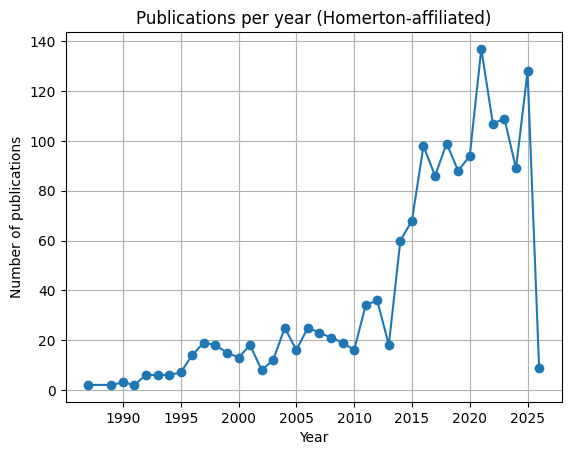

In [10]:
def extract_year(dp):
    if pd.isna(dp):
        return pd.NA
    s = str(dp)

    years = re.findall(r'\b(19\d{2}|20\d{2})\b', s)
    if not years:
        return pd.NA

    # Use the first year in strings like "2003 Dec-2004 Jan"
    return int(years[0])

df['year'] = df['date'].apply(extract_year).astype('Int64')

# Drop rows where year couldn't be parsed
year_counts = (
    df.dropna(subset=['year'])
      .groupby('year')
      .size()
      .sort_index()
)

# Plot
plt.figure()
year_counts.plot(marker='o')
plt.xlabel('Year')
plt.ylabel('Number of publications')
plt.title('Publications per year (Homerton-affiliated)')
plt.grid(True)
plt.savefig("homerton_publications_per_year.png", dpi=300, bbox_inches="tight")
plt.show()

In [22]:
df['doi'] = df['doi'].str.lower()
df['doi_url'] = df['doi'].apply(
    lambda d: f"https://doi.org/{d}" if pd.notna(d) and d else None
)

In [23]:
df.year.min()

np.int64(1987)

In [24]:
df.year.max()

np.int64(2026)

In [25]:
df.to_csv('homerton_papers.csv', index=False)

In [26]:
ri = pd.read_excel('01.10.25---30.12.25-Publications.xlsx', skiprows=1)

In [28]:
ri['Link'] = ri['Link'].str.lower()

In [29]:
df.head()

,pmid,author,author_affiliation,date,title,journal,pub_type,doi,year,doi_url
0,38297406,"Stier EA, Clarke MA, Deshmukh AA, Wentzensen N...","Department of Obstetrics and Gynecology, Bosto...",2024 May 15,International Anal Neoplasia Society's consens...,International journal of cancer,Journal Article,10.1002/ijc.34850,2024,https://doi.org/10.1002/ijc.34850
1,36418425,"Kulkarni S, Glover M, Kapil V, Abrams SML, Par...",Department of Clinical Pharmacology and Therap...,2023 Oct,Management of hypertensive crisis: British and...,Journal of human hypertension,"Journal Article, Review",10.1038/s41371-022-00776-9,2023,https://doi.org/10.1038/s41371-022-00776-9
2,31199090,"Vichinsky E, Hoppe CC, Ataga KI, Ware RE, Ndub...","From the University of California, San Francis...",2019 Aug 8,A Phase 3 Randomized Trial of Voxelotor in Sic...,The New England journal of medicine,"Clinical Trial, Phase III, Comparative Study, ...",10.1056/nejmoa1903212,2019,https://doi.org/10.1056/nejmoa1903212
3,38441162,"Benghanem S, Pruvost-Robieux E, Neligan A, Wal...","Medical Intensive Care Unit, Cochin hospital, ...",2024 Apr 1,Status epilepticus: what's new for the intensi...,Current opinion in critical care,"Journal Article, Review",10.1097/mcc.0000000000001137,2024,https://doi.org/10.1097/mcc.0000000000001137
4,37454287,"Whitcroft KL, Altundag A, Balungwe P, Boscolo-...","Smell and Taste Clinic, Department of Otorhino...",2023 Oct 1,Position paper on olfactory dysfunction: 2023.,Rhinology,"Consensus Development Conference, Journal Article",10.4193/rhin22.483,2023,https://doi.org/10.4193/rhin22.483


In [30]:
ri[~ri['Link'].isin(df['doi_url'])] # R&I papers apparently missing from pubmed search, none

,Number,Title,Author,Journal,Publisher / Website,Link


In [21]:
df[df.pmid == '40478922']

,pmid,author,author_affiliation,date,title,journal,pub_type,doi,year,doi_url
1402,40478922,"Sukumaran L, Winston A, Post FA, Anderson J, B...","Institute for Global Health, University Colleg...",2025 Oct 1,Changes in multimorbidity burden and their imp...,"AIDS (London, England)",Journal Article,10.1097/QAD.0000000000004260,2025,https://doi.org/10.1097/QAD.0000000000004260


In [38]:
df[df['year'] == 2025].date

10          2025 Jun
13          2025 Aug
17          2025 Sep
19          2025 Feb
20        2025 Mar 6
55          2025 Jul
59          2025 Aug
62       2025 Apr 11
64          2025 Oct
74       2025 Jun 30
82       2025 Jul 17
83       2025 Nov 14
84       2025 Aug 26
100         2025 May
104         2025 Dec
113      2025 Jul 14
119      2025 Jun 15
131      2025 Jul 28
134         2025 Jan
143         2025 Jun
149     2025 Jul-Aug
196         2025 Jun
201      2025 Aug 22
204         2025 Nov
231         2025 Dec
233         2025 Nov
254         2025 Sep
263      2025 Feb 14
275       2025 Dec 9
286      2025 Oct 10
295      2025 Dec 17
300      2025 Aug 20
304      2025 Jul 10
310      2025 Apr 27
323     2025 Mar-Apr
333       2025 Jan 7
355         2025 May
356         2025 Jan
364      2025 Aug 19
371      2025 May 21
394         2025 Jun
408      2025 Nov 19
409      2025 Jul 24
412         2025 Dec
417      2025 Feb 11
428         2025 Aug
432             2025
434         2

In [39]:
import pandas as pd
import re

MONTHS = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
    'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
    'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

def extract_month(dp):
    if pd.isna(dp):
        return pd.NA

    s = str(dp).lower()

    # find all month tokens (handles Jul-Aug, Mar-Apr, etc.)
    matches = re.findall(
        r'\b(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\b',
        s
    )

    if not matches:
        return pd.NA

    # take the first month mentioned
    return MONTHS[matches[0]]


In [40]:
df['month'] = df['date'].apply(extract_month).astype('Int64')


In [41]:
df['month_name'] = df['month'].map({
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
})


In [42]:
df[df['year'] == 2025][['date', 'month', 'month_name']].head(15)

,date,month,month_name
10,2025 Jun,6,Jun
13,2025 Aug,8,Aug
17,2025 Sep,9,Sep
19,2025 Feb,2,Feb
20,2025 Mar 6,3,Mar
55,2025 Jul,7,Jul
59,2025 Aug,8,Aug
62,2025 Apr 11,4,Apr
64,2025 Oct,10,Oct
74,2025 Jun 30,6,Jun


In [64]:
cut = df[(df['month'] > 9) & (df['year'] == 2025)] # oct-dec 2025

In [69]:
missing = cut[~cut.doi_url.isin(ri['Link'])]

In [76]:
missing.title.isin(ri['Title'])

585     False
695     False
698     False
699     False
1229    False
Name: title, dtype: bool

In [78]:
missing.style.hide(axis='index')

In [79]:
ri

,Number,Title,Author,Journal,Publisher / Website,Link
0,1,Refeeding Syndrome After Metabolic and Bariatr...,Triantafyllidis KK; Giannos P; Geropoulos G; S...,Obesity surgery [Obes Surg] 2025 Oct; Vol. 35 ...,Springer Nature Link,https://doi.org/10.1007/s11695-025-08186-9
1,2,Changes in multimorbidity burden and their imp...,Sukumaran L; Winston A; Post FA; Anderson J; B...,"AIDS (London, England) [AIDS] 2025 Oct 01; Vol...",AIDS,https://doi.org/10.1097/qad.0000000000004260
2,3,Challenging the Urologist of the Future: Time ...,Stangl FP; Heidegger I; Kraft P; Lammers RJM; ...,European urology [Eur Urol] 2025 Oct; Vol. 88 ...,Elsevier Ltd,https://doi.org/10.1016/j.eururo.2024.05.018
3,4,Prognostic factors predicting an unprovoked se...,Adan G; Neligan A; Nevitt SJ; Bonnett LJ; Sand...,The Cochrane database of systematic reviews [C...,Cochrane Library,https://doi.org/10.1002/14651858.cd013848.pub2
4,5,Atypical chest wall pain: paravertebral tuberc...,Amarnani R; Branley H; Chatterjee R,BMJ case reports [BMJ Case Rep] 2025 Oct 10; V...,BMJ Journals,https://doi.org/10.1136/bcr-2025-266521
5,6,Rethinking Breast Imaging Reporting and Data S...,Pradeep Kumar D; Chakiath AX; Sugunan A; Kandi...,"Cureus [Cureus] 2025 Oct 12; Vol. 17 (10), pp....",Cureus,https://doi.org/10.7759/cureus.94379
6,7,Withdrawing guideline-directed medical therapy...,Al-Aidarous S; Rajappan S; Ahluwalia N; Uy CP;...,Open heart [Open Heart] 2025 Oct 13; Vol. 12 (...,BMJ Journals,https://doi.org/10.1136/openhrt-2025-003733
7,8,Validating ChatGPT-4-Generated Patient Informa...,Henderson S; Reeves T; Somani B,\nJournal of endourology [J Endourol] 2025 Oct...,Mary Ann Liebert,https://doi.org/10.1177/08927790251387371
8,9,Traumatic Ankle Injuries in the Emergency Depa...,Anwar A; Ali MH; Ali H; Anwar W; Baalawi MS,"Cureus [Cureus] 2025 Oct 29; Vol. 17 (10), pp....",Cureus,https://doi.org/10.7759/cureus.95645
9,10,Automated retinal image analysis systems to tr...,Rudnicka AR; Shakespeare R; Chambers R; Bolter...,The Lancet. Digital health [Lancet Digit Healt...,The Lancet,https://doi.org/10.1016/j.landig.2025.100914


In [83]:
df[df.author.str.contains('Reynolds C')]

,pmid,author,author_affiliation,date,title,journal,pub_type,doi,year,doi_url,month,month_name
83,41232945,"Reynolds C, Callum J, Van Tongeren M",Homerton University Hospital NHS Foundation Tr...,2025 Nov 14,Characterising the contribution of inhalationa...,Thorax,Editorial,10.1136/thorax-2025-223536,2025,https://doi.org/10.1136/thorax-2025-223536,11,Nov


In [84]:
ri[ri.Author.str.contains('Reynolds C')]

,Number,Title,Author,Journal,Publisher / Website,Link
16,17,Characterising the contribution of inhalationa...,Reynolds C; Callum J; Van Tongeren M,"Thorax [Thorax] 2025 Nov 14; Vol. 80 (12), pp....",BMJ Journals,https://doi.org/10.1136/thorax-2025-223536


In [85]:
missing.to_csv('missing.csv', index=False)

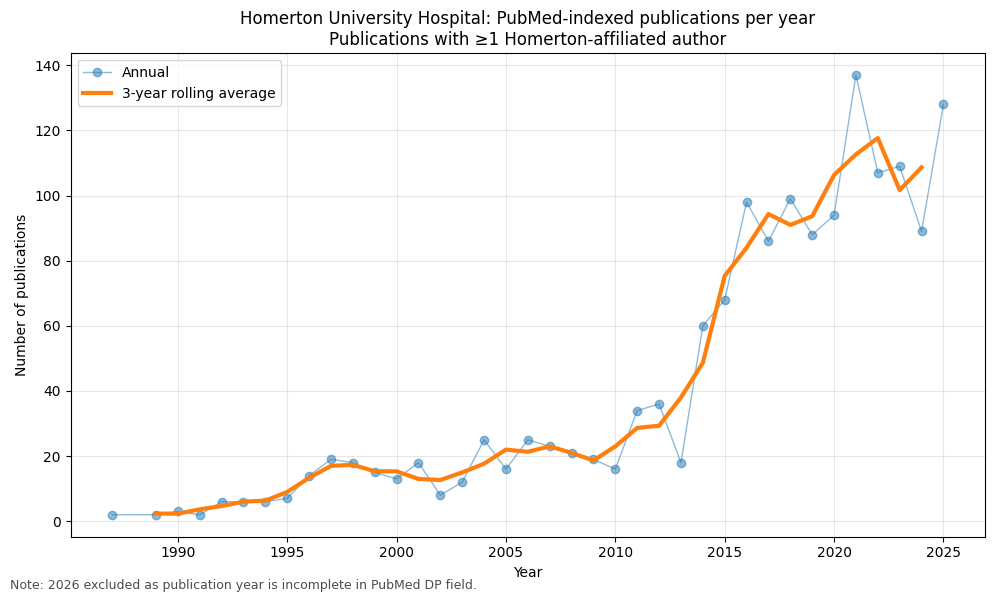

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

# --- build year_counts (assuming df['year'] already exists as Int64) ---
year_counts = (
    df.dropna(subset=['year'])
      .groupby('year')
      .size()
      .sort_index()
)

# --- drop incomplete current year (recommended) ---
current_year = pd.Timestamp.now().year
year_counts_plot = year_counts[year_counts.index < current_year]

# If you specifically want to drop 2026 regardless:
# year_counts_plot = year_counts[year_counts.index != 2026]

# --- plot ---
plt.figure(figsize=(10, 6))

# Annual counts (lighter)
year_counts_plot.plot(marker='o', linewidth=1, alpha=0.5, label='Annual')

# Rolling average (trend)
year_counts_plot.rolling(3, center=True).mean().plot(
    linewidth=3, label='3-year rolling average'
)

plt.xlabel('Year')
plt.ylabel('Number of publications')
plt.title(
    "Homerton University Hospital: PubMed-indexed publications per year\n"
    "Publications with ≥1 Homerton-affiliated author"
)

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.figtext(
    0.01, 0.01,
    f"Note: {current_year} excluded as publication year is incomplete in PubMed DP field.",
    ha="left", fontsize=9, alpha=0.7
)

# Save (do this before show)
plt.savefig("homerton_publications_per_year.png", dpi=300, bbox_inches="tight")
plt.savefig("homerton_publications_per_year.pdf", bbox_inches="tight")

plt.show()
